In [894]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno
import numpy as np
import plotly.express as px
import math

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

## 1 - Inspection des données et nettoyage

In [895]:
df = pd.read_csv('fr.openfoodfacts.org.products.csv', delimiter='\t')
df_unclean = df # save a copy of the dataframe for comparison

#Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types

C:\Users\Katrin\AppData\Local\Temp\ipykernel_16332\2685794014.py:1: DtypeWarning:

Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.



In [896]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [897]:
print("Le jeu de données compte {} lignes et {} variables.".format(df.shape[0], df.shape[1]))

Le jeu de données compte 320772 lignes et 162 variables.


In [898]:
df.dtypes.unique()

array([dtype('O'), dtype('float64')], dtype=object)

In [899]:
df_num = df.select_dtypes(include='number')
print("Le jeu de données compte {} variables numeriques.".format(df_num.shape[1]))

Le jeu de données compte 106 variables numeriques.


In [900]:
df_cat = df.select_dtypes(include='object')
print("Le jeu de données compte {} variables categorielles.".format(df_cat.shape[1]))

Le jeu de données compte 56 variables categorielles.


In [901]:
df_num.describe()

,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,0.0,248939.000000,248939.000000,0.0,248939.000000,0.0,0.0,2.611130e+05,857.000000,243891.000000,...,49.000000,3036.000000,165.000000,948.000000,0.0,268.000000,221210.000000,221210.000000,0.0,0.0
mean,NaN,1.936024,0.019659,NaN,0.055246,NaN,NaN,1.141915e+03,585.501214,12.730379,...,6.425698,31.458587,15.412121,49.547785,NaN,341.700764,9.165535,9.058049,NaN,NaN
std,NaN,2.502019,0.140524,NaN,0.269207,NaN,NaN,6.447154e+03,712.809943,17.578747,...,2.047841,31.967918,3.753028,18.757932,NaN,425.211439,9.055903,9.183589,NaN,NaN
min,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,8.000000,6.000000,NaN,0.000000,-15.000000,-15.000000,NaN,NaN
25%,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,3.770000e+02,49.400000,0.000000,...,6.300000,0.000000,12.000000,32.000000,NaN,98.750000,1.000000,1.000000,NaN,NaN
50%,NaN,1.000000,0.000000,NaN,0.000000,NaN,NaN,1.100000e+03,300.000000,5.000000,...,7.200000,23.000000,15.000000,50.000000,NaN,195.750000,10.000000,9.000000,NaN,NaN
75%,NaN,3.000000,0.000000,NaN,0.000000,NaN,NaN,1.674000e+03,898.000000,20.000000,...,7.400000,51.000000,15.000000,64.250000,NaN,383.200000,16.000000,16.000000,NaN,NaN
max,NaN,31.000000,2.000000,NaN,6.000000,NaN,NaN,3.251373e+06,3830.000000,714.290000,...,8.400000,100.000000,25.000000,100.000000,NaN,2842.000000,40.000000,40.000000,NaN,NaN


In [902]:
df_cat.describe()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url
count,320749,320749,320770,320769,320763,320772,320772,303010,52795,104819,...,221210,91513,94491,320726,320726,320726,84366,84366,75836,75836
unique,320638,320749,3535,189636,189568,180639,180495,221347,38584,13826,...,5,14,42,1021,1021,1021,3543,3543,75836,75836
top,24463061071,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489077120,2017-03-09T10:37:09Z,1439141742,2015-08-09T17:35:42Z,Ice Cream,Pâtes alimentaires au blé dur de qualité supér...,500 g,...,d,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",en:beverages,Boissons,http://fr.openfoodfacts.org/images/products/00...,http://fr.openfoodfacts.org/images/products/00...
freq,2,1,169868,20,20,33,33,410,201,4669,...,62763,22624,22624,168905,168905,168905,6054,6054,1,1


### Variables quantitatives

<AxesSubplot:>

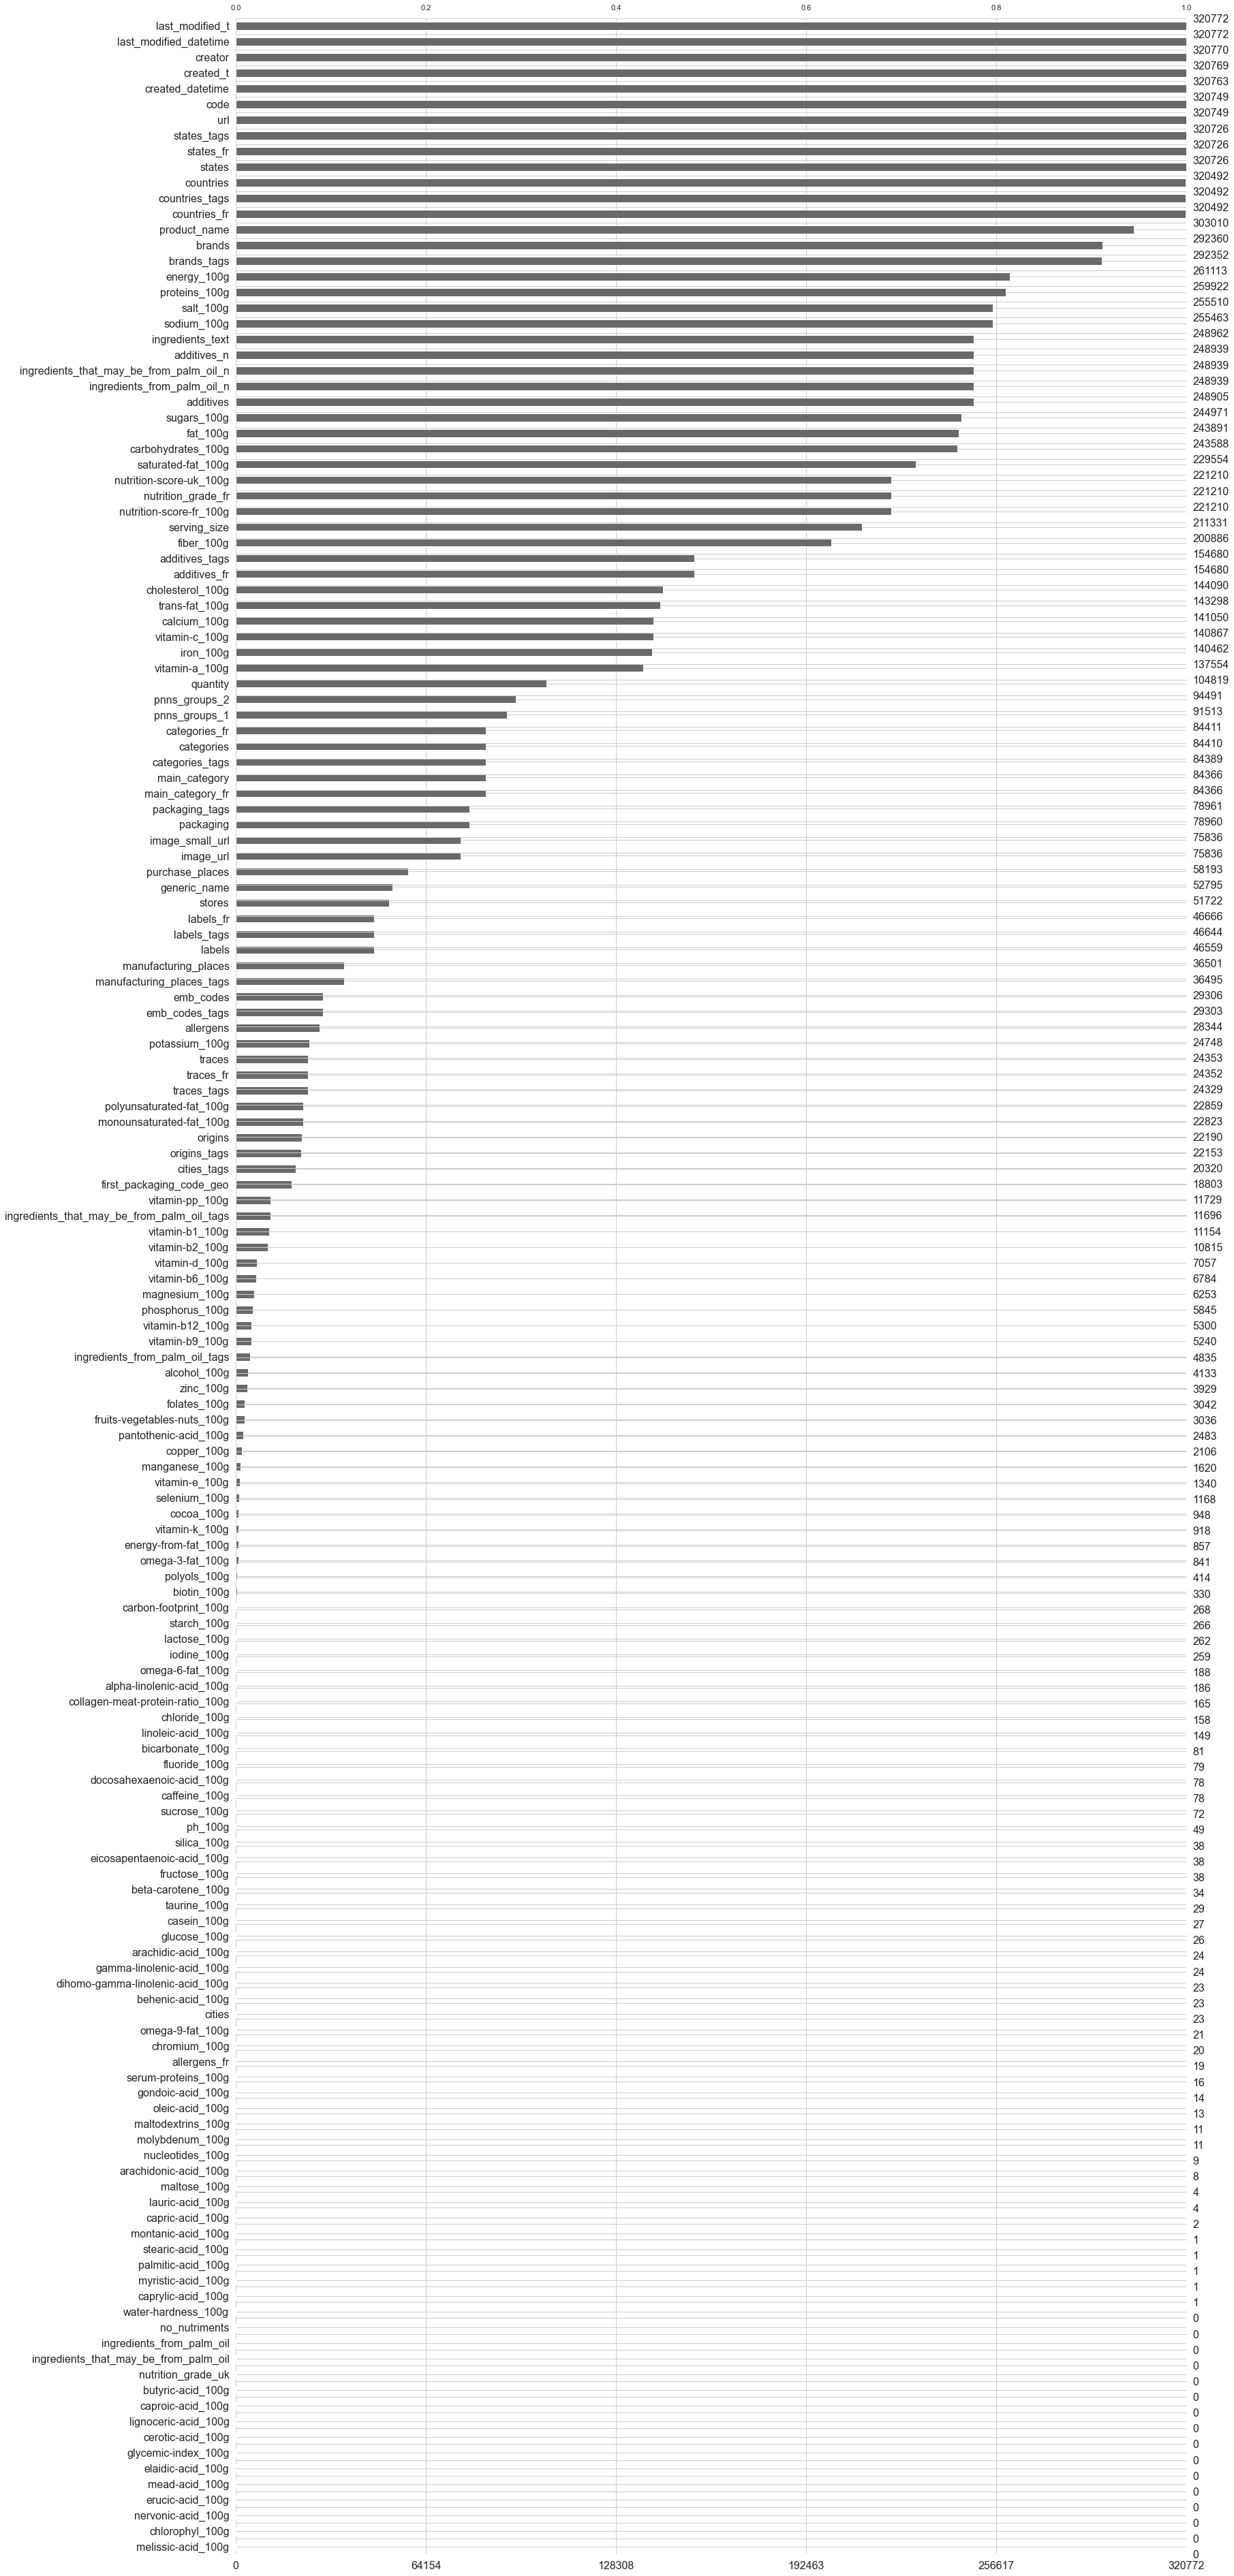

In [903]:
missingno.bar(df, sort='ascending')

In [904]:
limitPer = len(df) * .20
df = df.dropna(thresh=limitPer, axis=1)

In [905]:
# Rassembler les valeurs nutritives (variables qui contiennent le string "100g") 
columns100g = df.columns[df.columns.str.contains(pat = '100g')]

# NaN les valeurs négatives pour toutes les variables sauf nutrition-score-fr-100g qui peut descendre
# en dessous de 0
for column in df:
    if ((column in columns100g)&(column != "nutrition-score-fr_100g")):
        df.loc[df[column]< 0] = np.nan

# NaN toutes les valeurs qui dépassent 100g sauf energy_100g qui est calculé en kcal
for column in df:
    if ((column in columns100g)&(column != "energy_100g")):
        df.loc[df[column] > 100] = np.nan

In [906]:
df.shape

(320772, 54)

In [907]:
# remove outliers from energy_100g

Q1 = df["energy_100g"].quantile(0.25)
Q3 = df["energy_100g"].quantile(0.75)
IQR = Q3 - Q1

upper = Q3+1.5*IQR
lower = Q1+1.5*IQR

# remplacer les valeurs qui dépassent la limite supérieure par NaN

df.loc[df["energy_100g"]>upper,"energy_100g"] = np.nan

In [908]:
# Doublons

df = df.drop_duplicates(subset=['code'])

In [909]:
df_unclean
df.shape
print("Nous avons pu réduire la taille de notre dataset de {} variables à {} variables.".format(df_unclean.shape[1], format(df.shape[1])))
print("Nous avons pu réduire la taille de notre dataset de {} individus à {} individus.".format(df_unclean.shape[0], format(df.shape[0])))

Nous avons pu réduire la taille de notre dataset de 162 variables à 54 variables.
Nous avons pu réduire la taille de notre dataset de 320772 individus à 283077 individus.


Nous allons remplir les valeurs manquantes dans : fat_100g, carbohydrates_100g, sugars_100g, salt_100g, sodium_100g via IterativeImputer.

In [910]:
itimp_feats = ['fat_100g', 'carbohydrates_100g', 'sugars_100g', 'salt_100g', 'sodium_100g']

iter_imputer = IterativeImputer(random_state=0, max_iter=15)
iter_imputed = iter_imputer.fit_transform(df[itimp_feats])
df_iter_imputed = pd.DataFrame(iter_imputed, columns=itimp_feats)

df.update(df_iter_imputed)

Nous allons remplir les valeurs manquantes dans : saturated-fat_100g, fiber_100g et proteins_100g par 0.

In [911]:
tozero_feats = ["saturated-fat_100g", "fiber_100g", "proteins_100g"]
df[tozero_feats] = df[tozero_feats].fillna(0)
df[tozero_feats].isna().sum()

df['fat_100g'] = df['fat_100g'].fillna(0)

In [912]:
l = df.shape[0] - 1 # montant des boucles

In [913]:
def checkEnergy(i):
    formula = df.iloc[i]['proteins_100g']*4 + df.iloc[i]["carbohydrates_100g"]*4 + df.iloc[i]["fat_100g"]*9
    old = df.iloc[i]["energy_100g"]
    differ = abs(formula - old)
    if (differ > 100):
        df.iloc[i]["energy_100g"] = formula

In [914]:
def nanEnergy(i):
    newEnergy = df.iloc[i]['proteins_100g']*4 + df.iloc[i]["carbohydrates_100g"]*4 + df.iloc[i]["fat_100g"]*9
    df.iloc[i]["energy_100g"] = newEnergy

In [915]:
df["energy_100g"].isna().sum()

60187

In [919]:
num_feats = ['nutrition-score-fr_100g', 'energy_100g']

iter_imputer = IterativeImputer(random_state=0, max_iter=15)
iter_imputed = iter_imputer.fit_transform(df[num_feats])
df_iter_imputed = pd.DataFrame(iter_imputed, columns=[num_feats])

#df.update(df_iter_imputed)

In [920]:
b = df_iter_imputed["nutrition-score-fr_100g"]

In [921]:
df["nutrition-score-fr_100g"] = b

In [922]:
df["nutrition-score-fr_100g"].isna().sum()

34448

In [923]:
mn = round(df["nutrition-score-fr_100g"].mean())
me = round(df["energy_100g"].mean())
df["nutrition-score-fr_100g"] = df["nutrition-score-fr_100g"].fillna(mn)
df["energy_100g"] = df["energy_100g"].fillna(me)

In [928]:
df.select_dtypes(include='number').columns

Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'calcium_100g', 'iron_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g'],
      dtype='object')

In [929]:
df_num_selected = ['energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g']

In [930]:
df[df_num_selected].fillna(0, inplace=True)
df["carbohydrates_100g"].fillna(0, inplace=True)
df["sugars_100g"].fillna(0, inplace=True)
df["salt_100g"].fillna(0, inplace=True)
df["sodium_100g"].fillna(0, inplace=True)

C:\Users\Katrin\AppData\Local\Temp\ipykernel_16332\1959109357.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:>

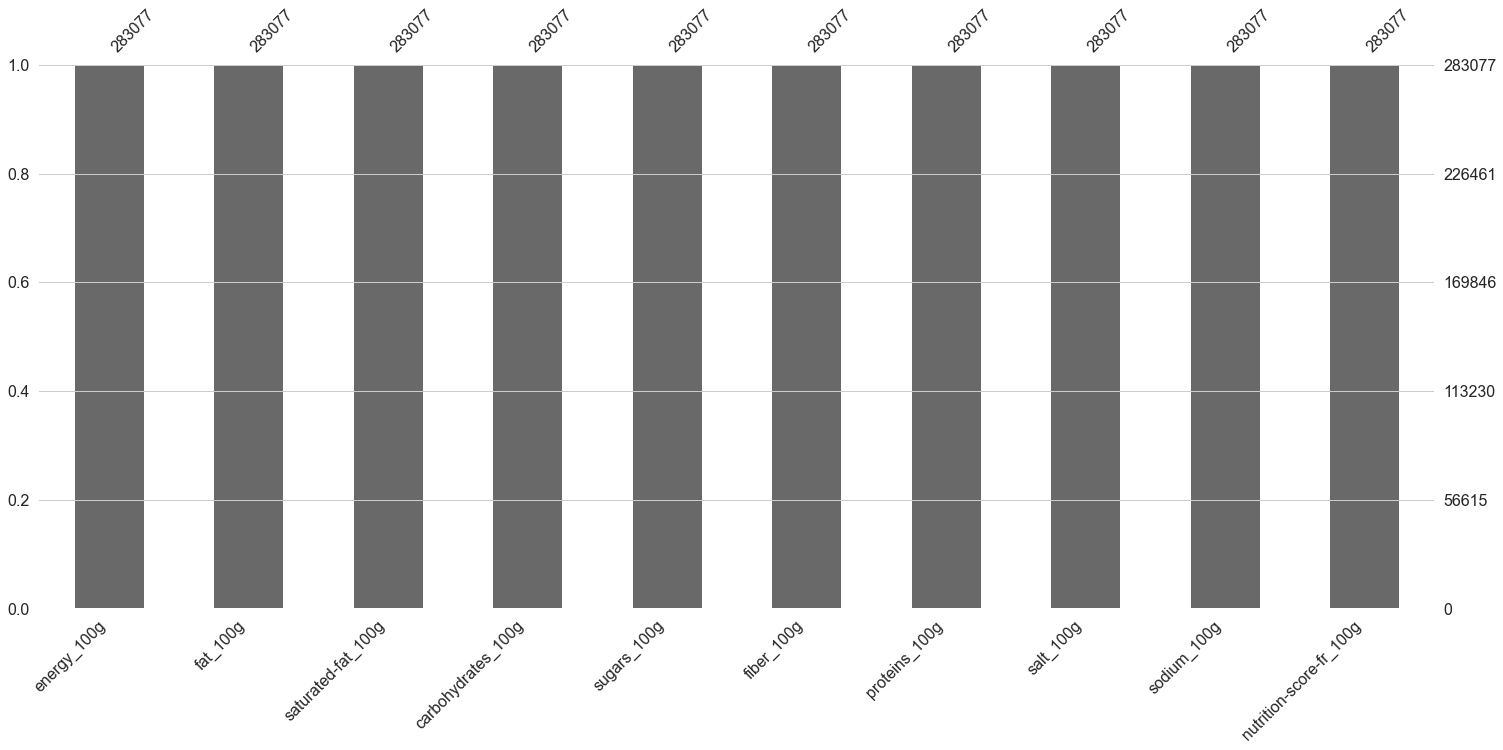

In [931]:
missingno.bar(df[df_num_selected])

### Variables qualitatives

In [932]:
df_cat_selected = ['product_name', 'categories', 'categories_tags', 'categories_fr', 'nutrition_grade_fr', 
                     'pnns_groups_1', 'pnns_groups_2', 'main_category', 'main_category_fr']

In [933]:
df_columns = df_cat_selected + df_num_selected
df = df[df_columns]

<AxesSubplot:>

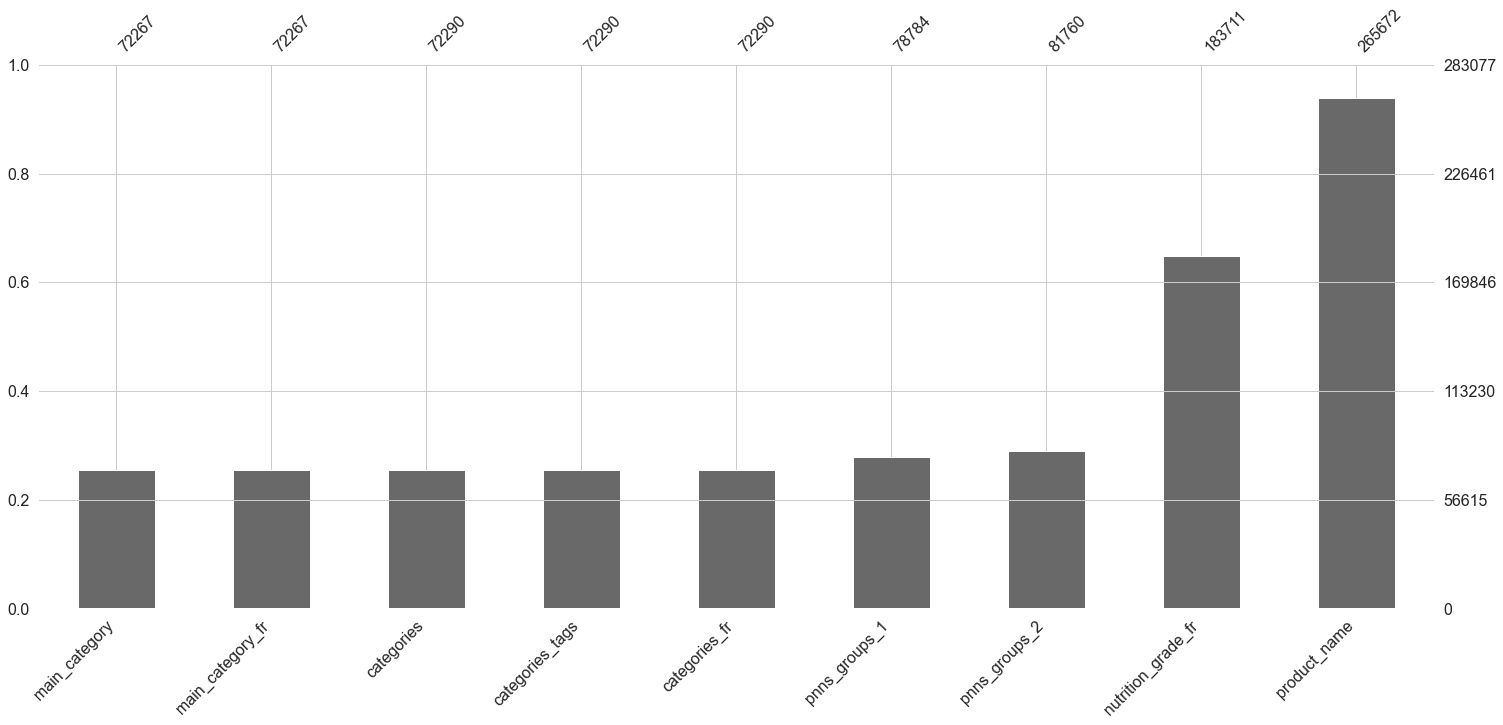

In [934]:
missingno.bar(df[df_cat_selected], sort="ascending")

In [935]:
df[df_cat_selected].isna().sum()

product_name           17405
categories            210787
categories_tags       210787
categories_fr         210787
nutrition_grade_fr     99366
pnns_groups_1         204293
pnns_groups_2         201317
main_category         210810
main_category_fr      210810
dtype: int64

<AxesSubplot:>

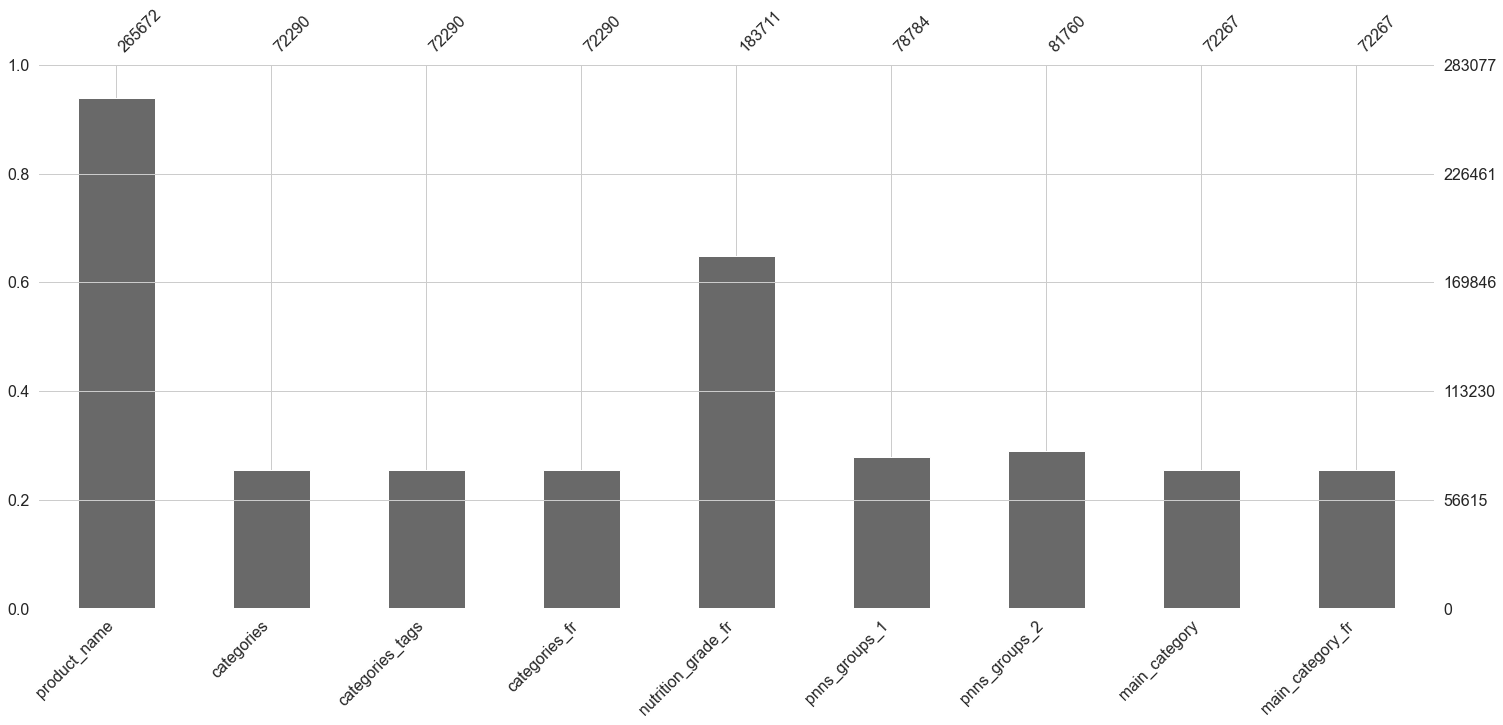

In [936]:
missingno.bar(df[df_cat_selected])

In [937]:
df[df_cat_selected].head(20)

,product_name,categories,categories_tags,categories_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,main_category,main_category_fr
0,Farine de blé noir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Banana Chips Sweetened (Whole),NaN,NaN,NaN,d,NaN,NaN,NaN,NaN
2,Peanuts,NaN,NaN,NaN,b,NaN,NaN,NaN,NaN
3,Organic Salted Nut Mix,NaN,NaN,NaN,d,NaN,NaN,NaN,NaN
4,Organic Polenta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Breadshop Honey Gone Nuts Granola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Organic Long Grain White Rice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Organic Muesli,NaN,NaN,NaN,c,NaN,NaN,NaN,NaN
8,Organic Dark Chocolate Minis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Organic Sunflower Oil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [938]:
ind_before = df.shape[0]
var_before = df.shape[1]

In [939]:
ind_before

283077

In [940]:
var_before

19

In [941]:
df.dropna(subset=df_cat_selected, thresh=5, inplace=True)

In [942]:
diff_ind = ind_before - df.shape[0]

Nous avons supprimé tous les individus pour lesquels il manque des données dans au moins 5 colonnes afin que le jeu de données devienne exploitable.

In [943]:
print("Le jeu de données a été réduite de {} individus.".format(diff_ind))

Le jeu de données a été réduite de 210810 individus.


<AxesSubplot:>

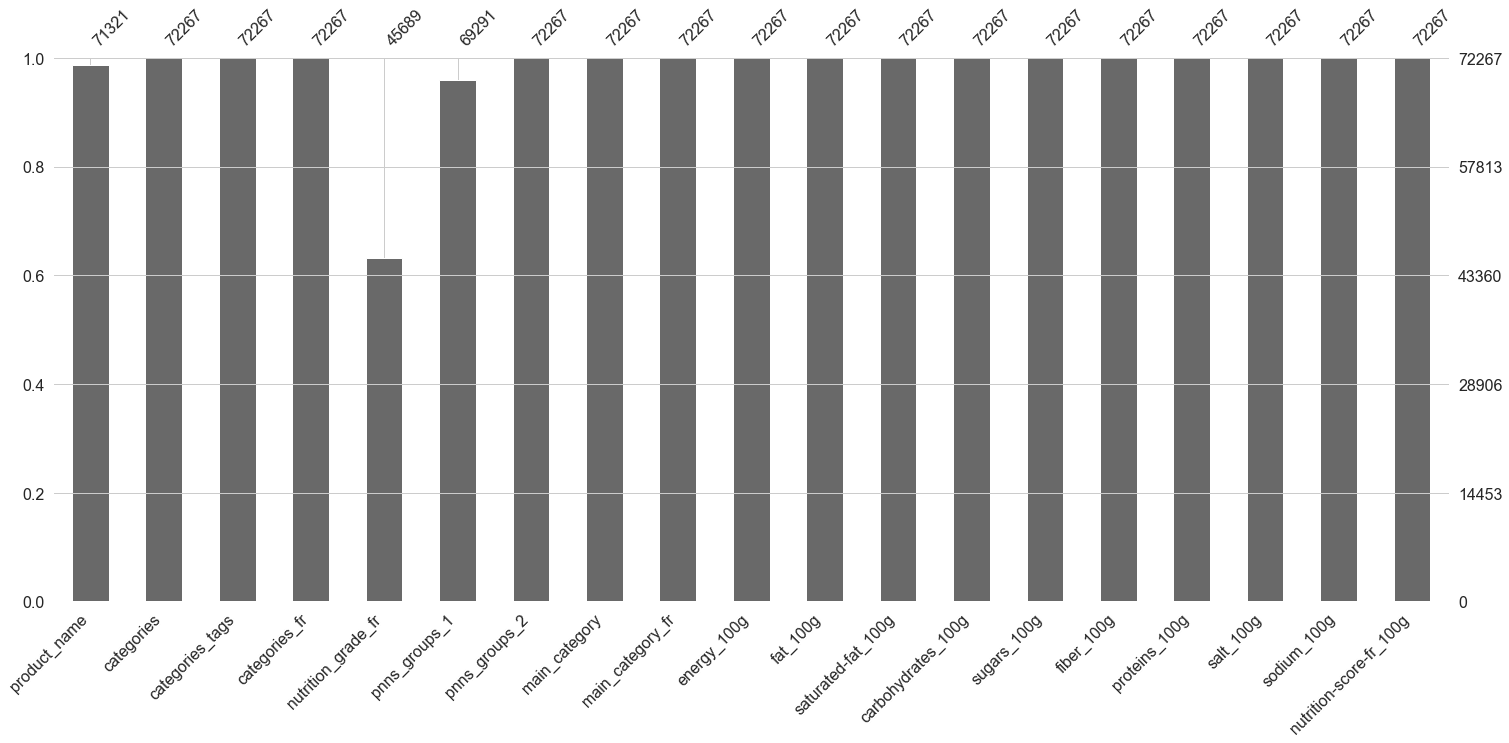

In [944]:
missingno.bar(df)

#### Nettoyage de nutrition grade : remplissage des valeurs manquantes

J'ai voulu remplacer les NaN dans nutrition_grade_fr à l'aide des nutrition-score-fr_100g mais avant de faire une boucle, qui est à éviter, j'ai analysé un peu les données que nous avons.   

Dans pnns_groups_1, nous pouvons constater que presque toutes les catégories d'aliments ont un nutrition score d'environ 11. 

In [945]:
df["pnns_groups_1"].fillna("unknown", inplace=True)
df["product_name"].fillna("unknown", inplace=True)

In [946]:
df["nutrition-score-fr_100g"].mean()

11.041524510499285

In [947]:
df["nutrition_grade_fr"].unique()

array([nan, 'c', 'b', 'e', 'd', 'a'], dtype=object)

In [948]:
df.groupby(["pnns_groups_1"]).mean()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
pnns_groups_1,,,,,,,,,,
Beverages,636.881050,12.431793,0.399238,26.389648,14.474200,0.147233,0.497263,1.375236,0.541431,11.066850
Cereals and potatoes,1379.067249,14.014197,1.994992,33.254117,14.382692,2.690962,7.438084,1.480102,0.582717,11.260493
Composite foods,796.081079,14.371028,2.474797,28.939592,14.402173,0.884810,6.570270,1.518782,0.597942,11.112182
Fat and sauces,1496.641029,17.359287,8.702047,25.283155,13.623599,0.382201,1.418392,1.632781,0.642828,11.061742
Fish Meat Eggs,984.052955,14.622431,3.220942,27.472688,14.262118,0.207843,13.258827,1.634860,0.643643,10.796402
Fruits and vegetables,952.789248,11.242695,0.774810,24.762861,12.679116,0.938526,1.103785,1.364379,0.537155,10.916606
Milk and dairy products,919.829742,14.788303,7.744139,28.508351,15.400443,0.139068,8.313877,1.395288,0.549327,11.022555
Salty snacks,2023.514521,16.660871,4.798324,34.203164,15.613520,2.906354,9.143626,1.502810,0.591656,11.309757
Sugary snacks,1712.415855,15.666588,7.917416,34.700021,19.636276,1.710698,4.399713,1.369179,0.539047,10.948718


In [950]:
boissons = df[df["pnns_groups_1"]=="Beverages"]
boissons["nutrition-score-fr_100g"].mean()

11.066849606635683

In [951]:
boissons["nutrition_grade_fr"].fillna('e', inplace=True)

C:\Users\Katrin\AppData\Local\Temp\ipykernel_16332\1292021005.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [952]:
nutriscoreC = df[df["pnns_groups_1"]==(("cereals-and-potatoes")or("Fruits and vegetables")or("Fish Meat Eggs")or("fruits-and-vegetables")or("Sugary snacks"))]
nutriscoreC["nutrition-score-fr_100g"].mean()

8.75

In [953]:
nutriscoreC["nutrition_grade_fr"].fillna('c', inplace=True)

C:\Users\Katrin\AppData\Local\Temp\ipykernel_16332\2939033900.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [954]:
df.update(boissons)
df.update(nutriscoreC)

In [955]:
df["nutrition_grade_fr"].fillna('d', inplace=True)

<AxesSubplot:>

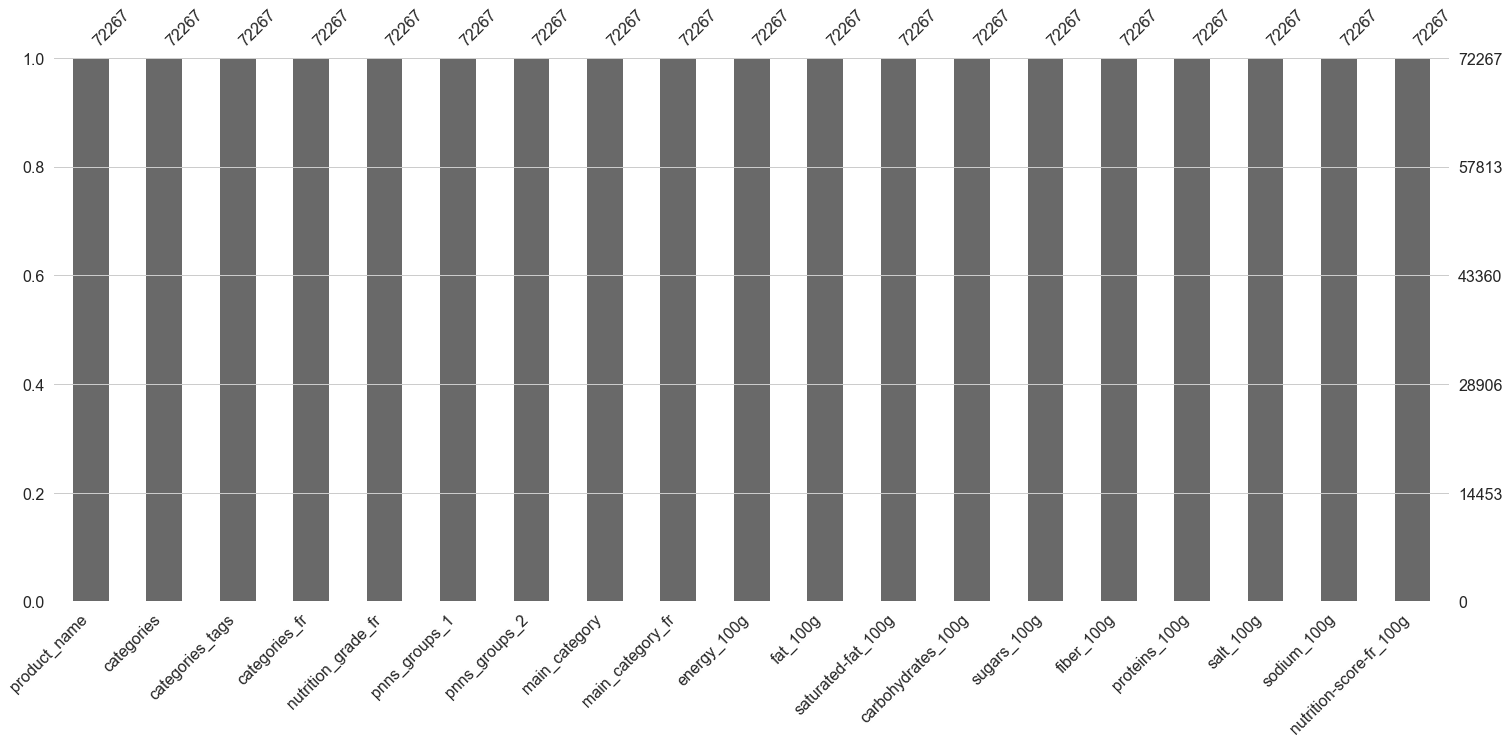

In [956]:
missingno.bar(df)

In [957]:
#le = LabelEncoder()

In [958]:
#def encodeCatCol(colName):
#    df[colName] = le.fit_transform(df[colName])

#def decodeCatCol(colName): 
#    df[colName] = le.inverse_transform(df[colName])

In [959]:
#for i in range (many):
#    encodeCatCol(df_cat_selected[i])

In [960]:
#df["product_name"] = le.fit_transform(df["product_name"])
#df['categories'] = le.fit_transform(df['categories'])
#df['categories_tags'] = le.fit_transform(df['categories_tags'])
#df['categories_fr'] = le.fit_transform(df['categories_fr'])
#df['nutrition_grade_fr'] = le.fit_transform(df['nutrition_grade_fr'])
#df['pnns_groups_1'] = le.fit_transform(df['pnns_groups_1'])
#df['pnns_groups_2'] = le.fit_transform(df['pnns_groups_2'])
#df['main_category'] = le.fit_transform(df['main_category'])
#df['main_category_fr'] = le.fit_transform(df['main_category_fr'])

In [961]:
#df["product_name"] = le.inverse_transform(df["product_name"])
#df['categories'] = le.inverse_transform(df['categories'])
#df['categories_tags'] = le.inverse_transform(df['categories_tags'])
#df['categories_fr'] = le.inverse_transform(df['categories_fr'])
#df['nutrition_grade_fr'] = le.inverse_transform(df['nutrition_grade_fr'])
#df['pnns_groups_1'] = le.inverse_transform(df['pnns_groups_1'])
#df['pnns_groups_2'] = le.inverse_transform(df['pnns_groups_2'])
#df['main_category'] = le.inverse_transform(df['main_category'])
#df['main_category_fr'] = le.inverse_transform(df['main_category_fr'])

In [962]:
#cat_encoded = df
#cat_encoded["product_name"] = le.fit_transform(df["product_name"])
#cat_encoded["product_name"]

#df["product_name"] = le.inverse_transform(df["product_name"])

## 2 - Analyse des données

### Analyse univariée variables qualitatives

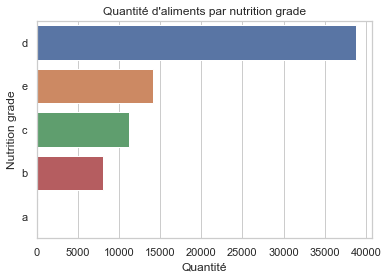

In [1049]:
# Aliments par nutrition grade

foods_count = df['nutrition_grade_fr'].value_counts().index
sns.countplot(y="nutrition_grade_fr", order=foods_count, data=df);
plt.title("Quantité d'aliments par nutrition grade")
plt.xlabel("Quantité")
plt.ylabel("Nutrition grade")
plt.show()

In [1027]:
df.groupby(['nutrition_grade_fr']).mean()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
nutrition_grade_fr,,,,,,,,,,
a,366.019444,11.076654,0.119444,28.499197,14.856949,0.212500,0.973611,1.004499,0.395472,11.169289
b,583.188027,13.362004,1.147546,29.385206,14.319306,1.277843,6.153660,1.443226,0.568198,11.031824
c,927.743886,14.171651,2.667262,29.898308,15.050517,1.891659,7.457554,1.479401,0.582438,11.011626
d,1267.105277,14.195276,3.317933,28.860371,14.861206,0.690994,4.708702,1.527359,0.601322,11.076406
e,1556.178967,15.947189,10.079965,30.956040,17.565497,0.775813,5.314700,1.477279,0.581600,10.974282


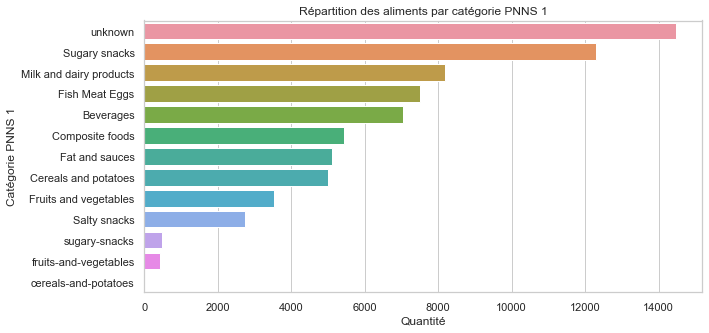

In [1043]:
# Aliments par pnns1

plt.figure(figsize=(10, 5))
foods_count = df['pnns_groups_1'].value_counts().index
sns.countplot(y='pnns_groups_1', order=foods_count, data=df);
plt.title("Répartition des aliments par catégorie PNNS 1")
plt.xlabel("Quantité")
plt.ylabel("Catégorie PNNS 1")
plt.show()

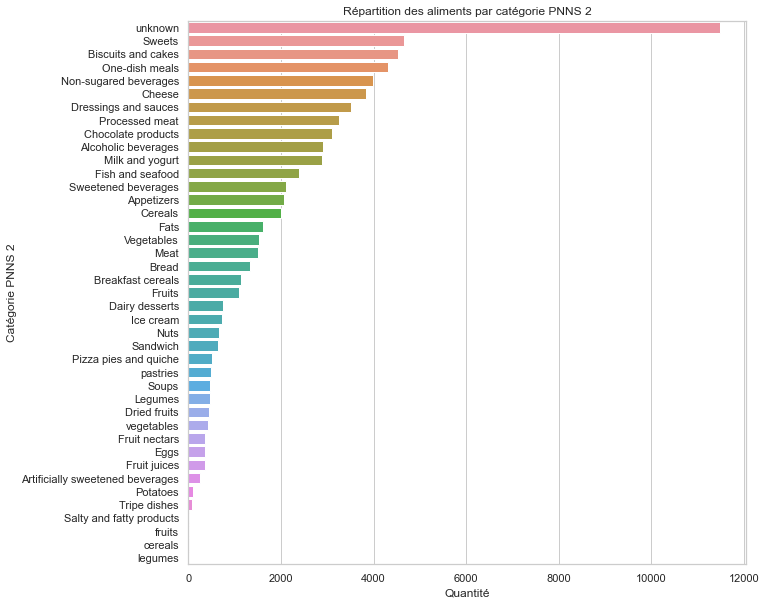

In [1044]:
# Aliments par pnns2

plt.figure(figsize=(10, 10))
foods_count = df['pnns_groups_2'].value_counts().index
sns.countplot(y='pnns_groups_2', order=foods_count, data=df);
plt.title("Répartition des aliments par catégorie PNNS 2")
plt.xlabel("Quantité")
plt.ylabel("Catégorie PNNS 2")
plt.show()

### Analyse bivariée variables qualitatives

In [1037]:
# nutri-grade et categorie d'aliment

fig = px.histogram(df, x='pnns_groups_1', color='nutrition_grade_fr', 
        title = 'Répartition des aliments en fonction de leur nutrition grade et catégorie')

fig.show()

### Analyse univariée variables quantitatives

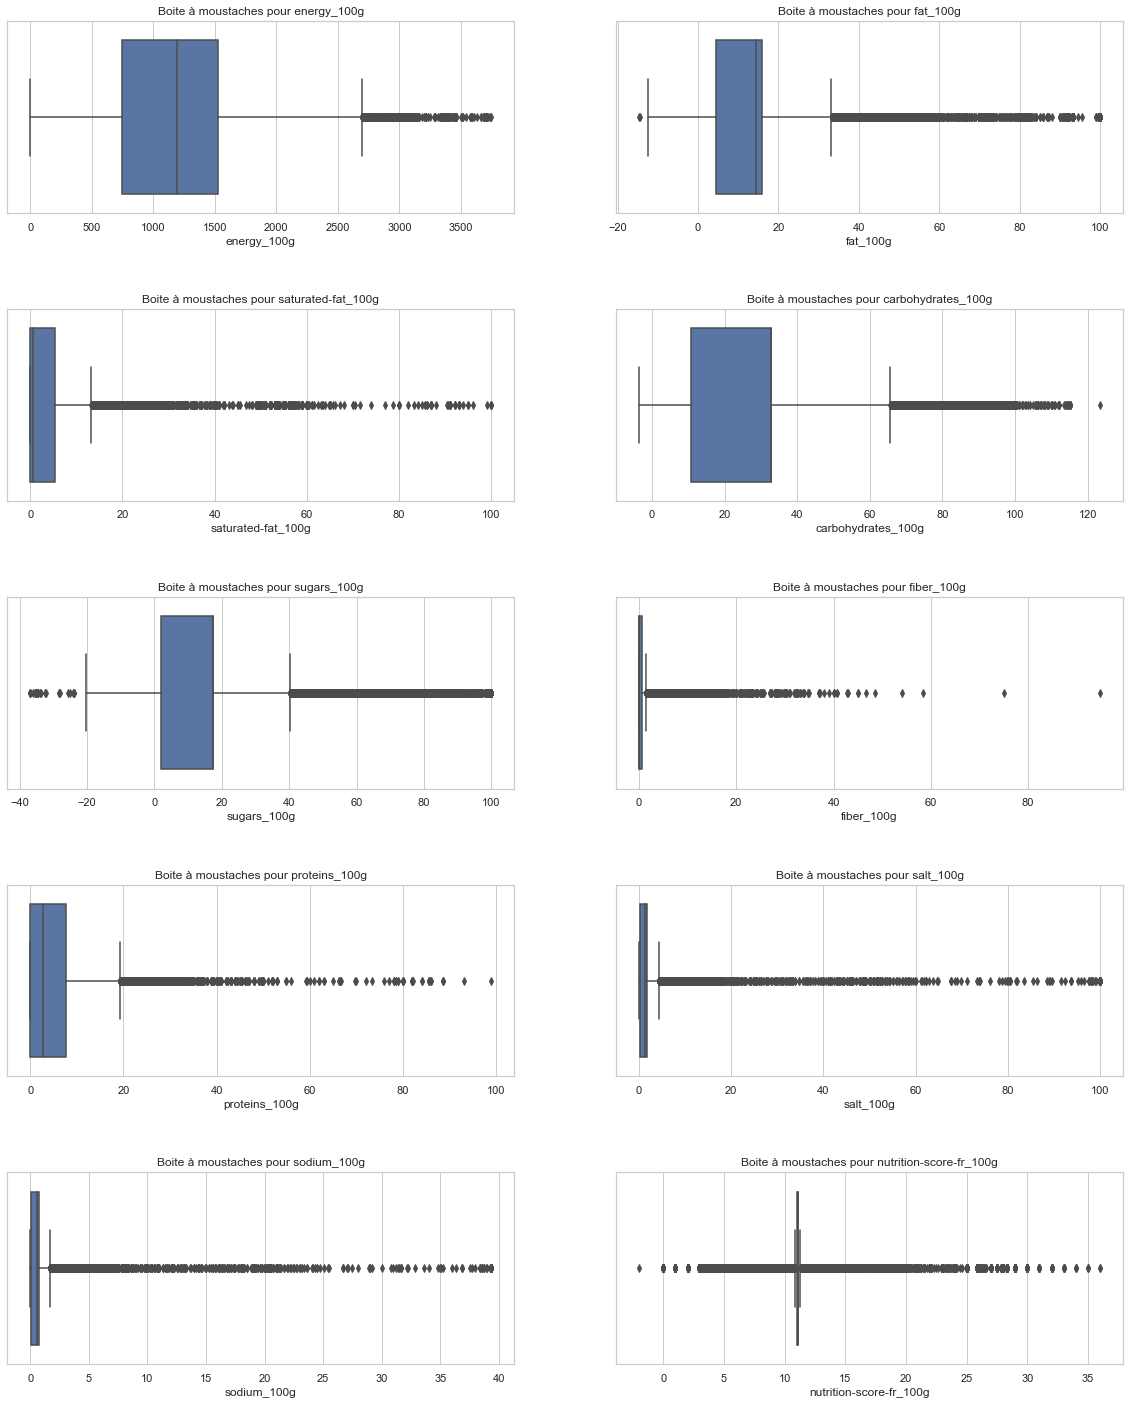

In [967]:
# Box plots

vars = df_num_selected

nbr_rows = int(len(vars)/2) + 1
index = 1
plt.figure(figsize=(20,30))
plt.subplots_adjust(hspace=0.5)

for column in vars:
    plt.subplot(nbr_rows, 2, index)
    sns.boxplot(x=df[column])
    plt.xlabel(column)
    plt.title(f"Boite à moustaches pour {column}")
    index += 1
plt.show()

### Analyse multivariée variables quantitatives

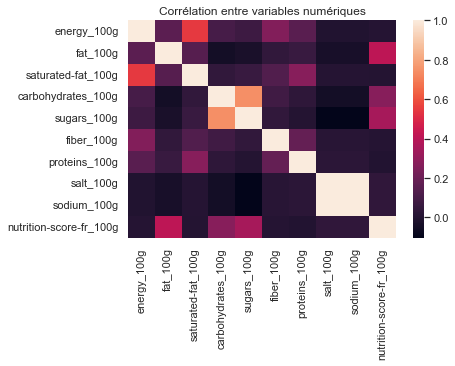

In [1046]:
# Correlation entre 100g

sns.heatmap(df[df_num_selected].corr())
plt.title("Corrélation entre variables numériques")
plt.show()

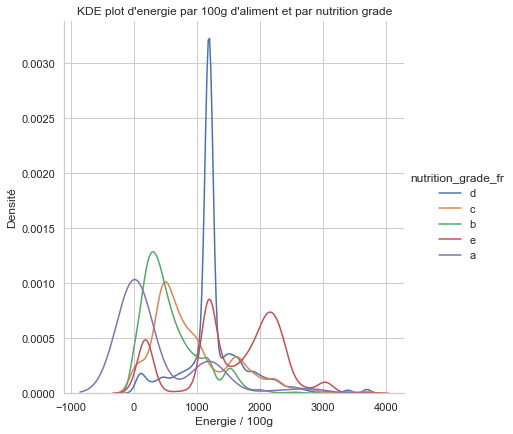

In [1048]:
sns.FacetGrid(df, hue="nutrition_grade_fr", height=6).map(sns.kdeplot, "energy_100g").add_legend()
plt.title("KDE plot d'energie par 100g d'aliment et par nutrition grade")
plt.xlabel("Energie / 100g")
plt.ylabel("Densité")
plt.show()

## Principal Component Analysis

In [973]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn import preprocessing
import functions

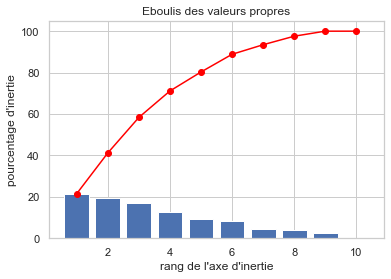

In [974]:
# Eboulis des valeurs propres

acp_vars = df_num_selected
X = df[acp_vars].dropna()
keep_ind = X.index
X = StandardScaler().fit_transform(X)

pca = decomposition.PCA(n_components=len(acp_vars))
pca.fit(X)
X = pca.transform(X)

functions.display_scree_plot(pca)

Nous allons garder les 4 premiers rangs de l'axe d'inértie pour la suite de l'ACP.

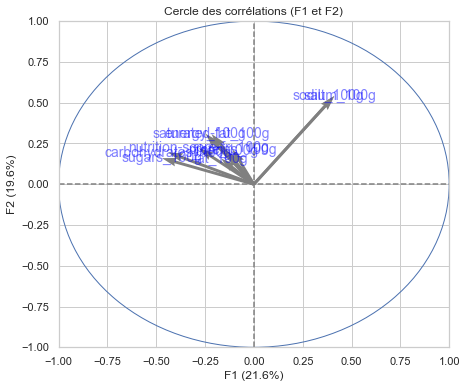

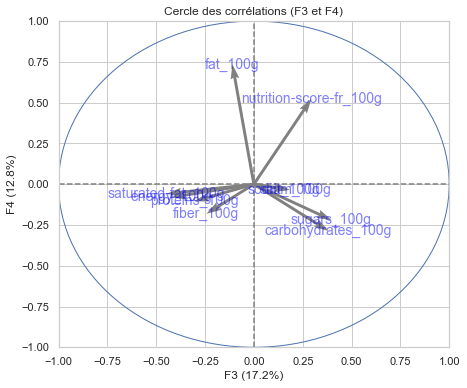

In [975]:
# Cercle des corrélations (F1 & F2) , (F3 & F4)

pcs = pca.components_
functions.display_circles(pcs, 4, pca, [(0,1),(2,3),(4,5)], labels = np.array(acp_vars))

Les informations concernant les composantes selon les cercles de corrélation :  

* La composante F1 : corrélée avec le sel et le sodium. En se déplacant sur la composante F2, nous obtenons les aliments de plus en plus salés et riches en sodium, ainsi que moins sucrés et moins riches en glucides. Le nutri-score est très légèrement négativement corrélé à la composante F1 et aux aliments salés.
* La composante F2 : corrélée positivement avec les aliments gras, sucrés, et salés. 
* La composante F3 : corrélée positivement avec les sucres, les glucides et le nutrition_score, négativement avec le gras saturé, les protéines, les fibres. 
* La composante F4 : corrélée positivement avec le gras et le nutrition_score, négativement avec les sucres, les glucides, les fibres, proteines et le gras saturé.  

Les hypothèses que nous pouvons tirer de l'ACP sont donc que :  

* Les aliments avec un nutri-grade de A : 
* Nutri-grade de B : 
* Nutri-grade de C :
* Nutri-grade de D : 
* Nutri-grade de E : 

## ANOVA

In [976]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

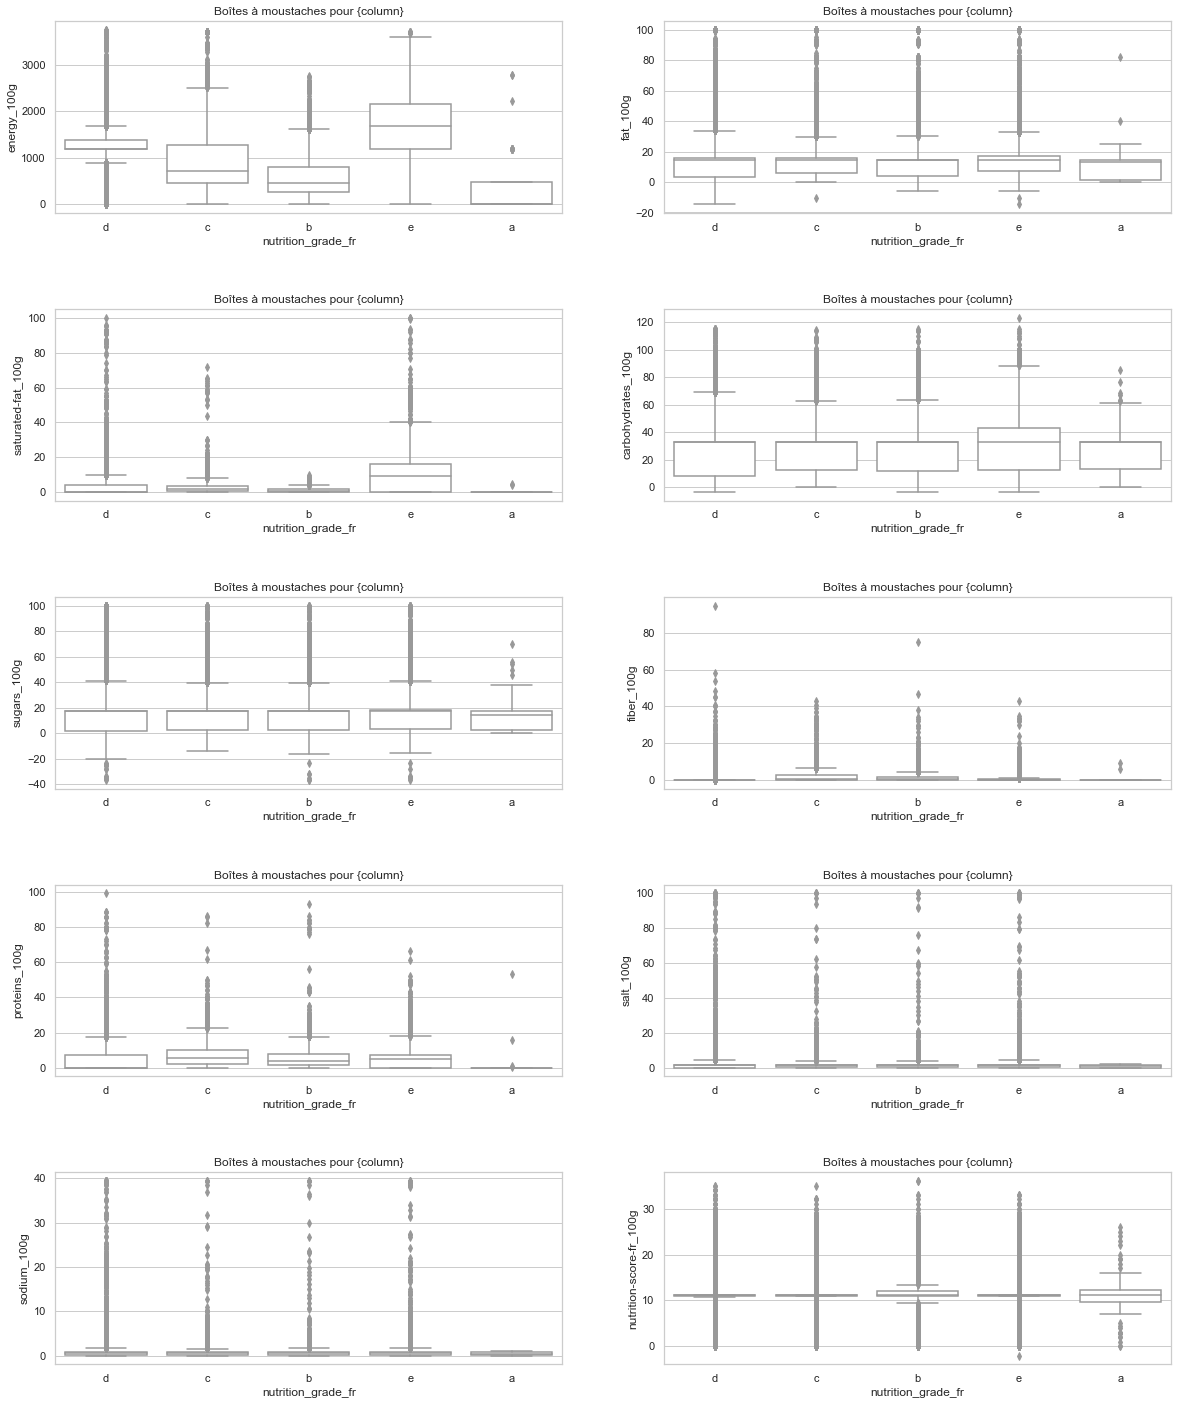

In [984]:
vars = df_num_selected

nbr_rows = int(len(vars)/2) + 1
index = 1
plt.figure(figsize=(20,30))
plt.subplots_adjust(hspace=0.5)

for column in vars:
    
    plt.subplot(nbr_rows, 2, index)
    ax = sns.boxplot(x="nutrition_grade_fr", y=column, data=df, color='white')
    #ax.set_ylim(0, 50)
    plt.xlabel('nutrition_grade_fr')
    plt.ylabel(column)
    plt.title('Boîtes à moustaches pour {column}')
    index += 1

plt.show()

In [1003]:
num_fisher = ['energy_100g','fat_100g','carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g']

In [1018]:
l = []
for i in range (len(num_fisher)):
    col = num_fisher[i]
    anova_variete = smf.ols('{}~nutrition_grade_fr'.format(col), data=df).fit()
    f_table = sm.stats.anova_lm(anova_variete, typ=2)
    f_value = f_table.loc['nutrition_grade_fr']['PR(>F)']
    l.append(f_value)

In [1019]:
d = {'Variable': num_fisher, 'PR(>F)': l}
fisher_df = pd.DataFrame(data=d)
fisher_df

,Variable,PR(>F)
0,energy_100g,0.000000e+00
1,fat_100g,1.221253e-48
2,carbohydrates_100g,5.461588e-20
3,sugars_100g,2.455110e-68
4,fiber_100g,0.000000e+00
5,proteins_100g,3.766278e-286
6,salt_100g,2.671242e-01
7,sodium_100g,2.670513e-01


Values not correlated to the nutrition_grade_fr variable (p-value > 5%) : 
* salt, sodium  

Variables highly correlated to the nutrition_grade_fr variable (p-value << 5%) : 
* fat, carbohydrates, sugars, proteins  

Variables slightly correlated to the nutrition_grade_fr variable (p-value < 5%) : 
* energy, fiber

# Synthèse

...